## 8

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0310 - val_loss: 0.0109
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0051 - val

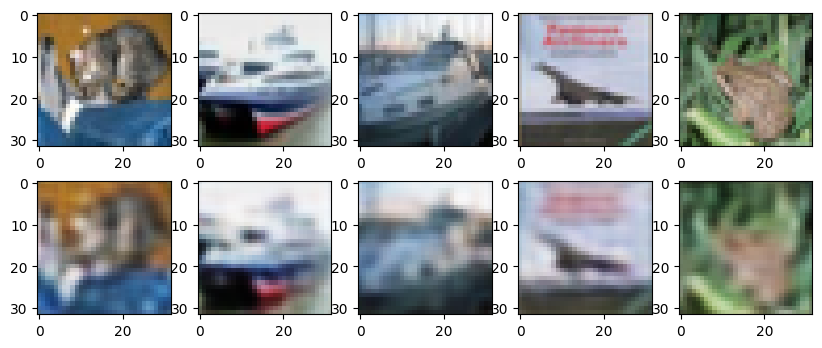

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Autoencoder architecture
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Training
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Metrics
original_size = 32 * 32 * 3  # 3072
compressed_size = 8 * 8 * 16  # 1024
compression_ratio = original_size / compressed_size
print(f"Compression Ratio: {compression_ratio:.2f}:1")

# Reconstruction quality
def psnr(x, y):
    return -10 * np.log10(np.mean((x-y)**2))

test_reconstructions = autoencoder.predict(x_test[:10])
print(f"PSNR: {psnr(x_test[0], test_reconstructions[0]):.2f} dB")

# Visualization
plt.figure(figsize=(10, 4))
for i in range(5):
    # Original
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i])

    # Reconstructed
    plt.subplot(2, 5, i+6)
    plt.imshow(test_reconstructions[i])
plt.show()

## 9

Epoch 1/2
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.1827
Epoch 2/2
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.0891
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


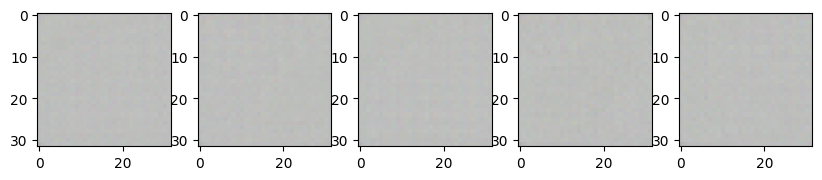

In [3]:
from tensorflow.keras import Sequential, layers

# Generator model
generator = Sequential([
    layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((8, 8, 256)),

    layers.Conv2DTranspose(128, (4,4), strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(64, (4,4), strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(3, (4,4), padding='same', activation='tanh')
])

# Simple generation process
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Training setup (simple version)
generator.compile(optimizer='adam', loss='mse')

# Generate targets (simplified example)
# In practice you'd need adversarial training
dummy_labels = np.random.rand(len(x_train), 32, 32, 3)
generator.fit(np.random.randn(len(x_train), 100),
             dummy_labels,
             epochs=2,
             batch_size=256)

# Generate samples
samples = generator.predict(tf.random.normal([10, 100]))

# Visualization
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow((samples[i] + 1)/2)  # Scale from [-1,1] to [0,1]
plt.show()

## 10

In [5]:
from tensorflow.keras import Model

# Load MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 127.5 - 1

# Generator
def make_generator():
    model = Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=2, padding='same',
                              activation='tanh')
    ])
    return model

# Discriminator
def make_discriminator():
    return Sequential([
        layers.Conv2D(64, (5,5), strides=2, padding='same',
                     input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])

# GAN setup
generator = make_generator()
discriminator = make_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def train_gan(epochs=2, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices(
        x_train).shuffle(60000).batch(batch_size)

    for epoch in range(epochs):
        for real_images in dataset:
            # Train discriminator
            noise = tf.random.normal([batch_size, 100])
            fake_images = generator(noise)

            d_loss_real = discriminator.train_on_batch(
                real_images, tf.ones((batch_size, 1)) * 0.9)  # Label smoothing
            d_loss_fake = discriminator.train_on_batch(
                fake_images, tf.zeros((batch_size, 1)))
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train generator
            noise = tf.random.normal([batch_size, 100])
            g_loss = gan.train_on_batch(
                noise, tf.ones((batch_size, 1)))

        print(f"Epoch {epoch+1}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Combine models
discriminator.compile(optimizer='adam', loss=cross_entropy)
discriminator.trainable = False
gan = Model(generator.input, discriminator(generator.output))
gan.compile(optimizer='adam', loss=cross_entropy)

# Training
train_gan(epochs=2)

# Generate samples
samples = generator.predict(tf.random.normal([10, 100]))

# Visualization
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(samples[i].reshape(28,28) * 0.5 + 0.5, cmap='gray')
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: The layer sequential_2 has never been called and thus has no defined input.